In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import zipfile
import os, shutil
import pathlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive


drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/ai_vs_real_photos.zip'
extract_path = '/content/datasets'

# if os.path.exists(extract_path):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
#     shutil.rmtree(extract_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 추출된 데이터 경로
data_dir = extract_path

data_dir = pathlib.Path(data_dir).with_suffix('')

image_count = len(list(data_dir.rglob('*.jpg')))

print(image_count)

Mounted at /content/drive
435


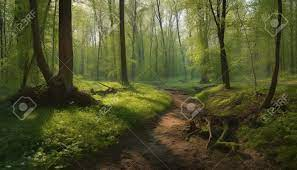

In [2]:
ai_images = list(data_dir.rglob('ai_images/*'))
PIL.Image.open(str(ai_images[0]))

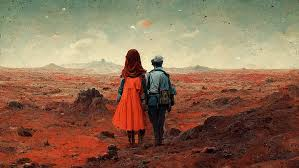

In [3]:
PIL.Image.open(str(ai_images[1]))

In [ ]:
camera_images = list(data_dir.rglob('camera_images/*'))
PIL.Image.open(str(camera_images[0]))

In [ ]:
PIL.Image.open(str(camera_images[1]))

In [5]:
batch_size = 32
img_height = 180
img_width = 180

data_dir = os.path.join(data_dir, 'ai_vs_real_photos')

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation", # 검증 데이터셋
  seed=123, # 데이터 분할할 때 쓰는 랜덤 값
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 454 files belonging to 2 classes.
Using 364 files for training.
Found 454 files belonging to 2 classes.
Using 90 files for validation.
['ai_images', 'camera_images']


In [11]:
for images, labels in train_ds.take(1):  # 첫번째 배치만 가져와라,
    # 배치에서 첫 번째 이미지를 가져옵니다.
    image = images[31].numpy().astype("uint8") #  batch_size가 32이기 때문에 그 이상보다 크면 index error
    # 이미지를 표시합니다.
    plt.imshow(image)
    plt.show()

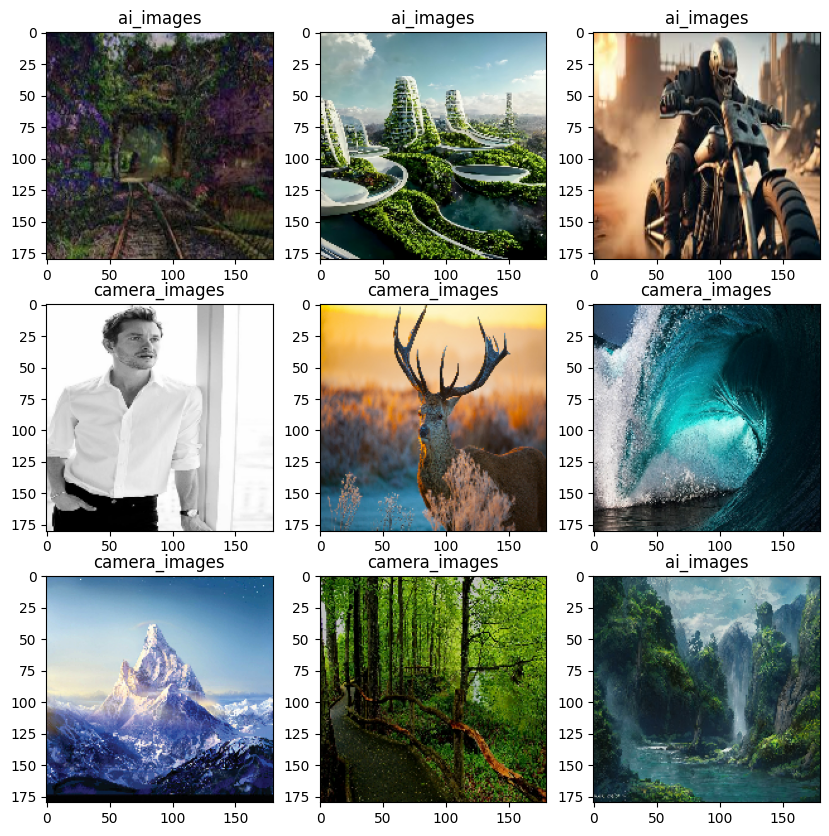

In [12]:
plt.figure(figsize=(10, 10)) # 가로세로 10인치 그림 생성 흰배경인듯
for images, labels in train_ds.take(1): # 첫번째 배치만 가져옴
  for i in range(9): # 첫번째 배치에서 처음 9개의 이미지
    ax = plt.subplot(3, 3, i + 1) # 생성한 이미지를 3x3 격자로 분할하겠다, 격자의 각 위치에 생성하겠다,
    plt.imshow(images[i].numpy().astype("uint8")) # 9 분할된 이미지 보여줘
    plt.title(class_names[labels[i]]) # 이름 붙임
   # plt.axis("off") # 축에 가로세로 정보 비활성화
   # print(plt.imshow(images[i].numpy().astype("uint8")))

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)  # 샘플32개 가로 세로 rgb채널
  print(labels_batch.shape) # 정답지 이름
  break

for label in labels_batch:
  i = label.numpy().astype("uint8")
  print(i)
  print(class_names[labels[i]])

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # 훈련 데이터를 메모리에 로드하고 유지, 데이터 샘플을 무작위로 섞어서 순서를 배우지않도록함, 데이터의 샘플수보다 크거나 같은값이 좋음
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # 훈련하는동안 데이터전처리 병행

In [17]:
normalization_layer = layers.Rescaling(1./255) # 0~255범위의 값의 수치를 정규화시키는 과정 , 1/255 를 곱한것

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
num_classes = len(class_names) # 정답지 갯수

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'), # 16개의 feature, padding='same'은 입력과 출력의 크기를 동일하게 , 필터의 크기는 3*3, relu 비선형 활성화 함수로 음수는 0, 양수는 그대로
  layers.MaxPooling2D(), # 과적합 방지
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(), # 2D 인 이미지를 1 Demension 으로 변환
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes) # 정답지 갯수만큼
])


# import numpy as np
# import matplotlib.pyplot as plt

# # 28x28 크기의 RGB 이미지 생성을 위한 무작위 배열 생성
# # np.random.rand()는 0과 1 사이의 난수를 생성하므로, 255를 곱해 RGB 범위에 맞춥니다.
# image = np.random.rand(28, 28, 3) * 255

# # numpy 배열을 uint8 타입으로 변환
# image = image.astype(np.uint8)

# # 이미지 시각화
# plt.imshow(image)
# plt.axis('off')  # 축 정보 비활성화
# plt.show()

# print(image)



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
12/12 [==============================] - 15s 1s/step - loss: 1.0674 - accuracy: 0.4972 - val_loss: 0.6921 - val_accuracy: 0.5333
Epoch 2/10
12/12 [==============================] - 14s 1s/step - loss: 0.6635 - accuracy: 0.5978 - val_loss: 0.6828 - val_accuracy: 0.5667
Epoch 3/10
12/12 [==============================] - 12s 1s/step - loss: 0.5962 - accuracy: 0.6704 - val_loss: 0.6269 - val_accuracy: 0.6556
Epoch 4/10
12/12 [==============================] - 12s 1s/step - loss: 0.5422 - accuracy: 0.7514 - val_loss: 0.5806 - val_accuracy: 0.7444
Epoch 5/10
12/12 [==============================] - 13s 1s/step - loss: 0.4373 - accuracy: 0.8017 - val_loss: 0.5653 - val_accuracy: 0.6667
Epoch 6/10
12/12 [==============================] - 12s 1s/step - loss: 0.3618 - accuracy: 0.8352 - val_loss: 0.6583 - val_accuracy: 0.6333
Epoch 7/10
12/12 [==============================] - 14s 1s/step - loss: 0.2873 - accuracy: 0.8939 - val_loss: 0.5241 - val_accuracy: 0.7444
Epoch 8/10
12/12 [==

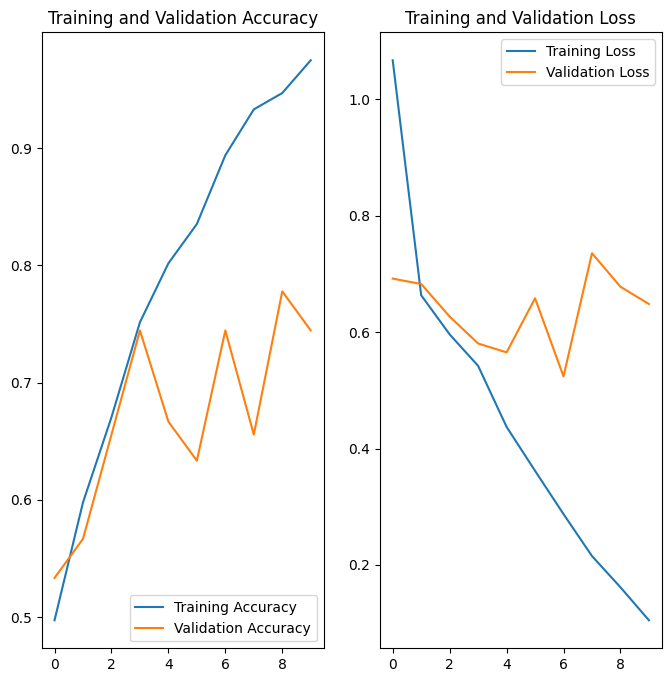

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

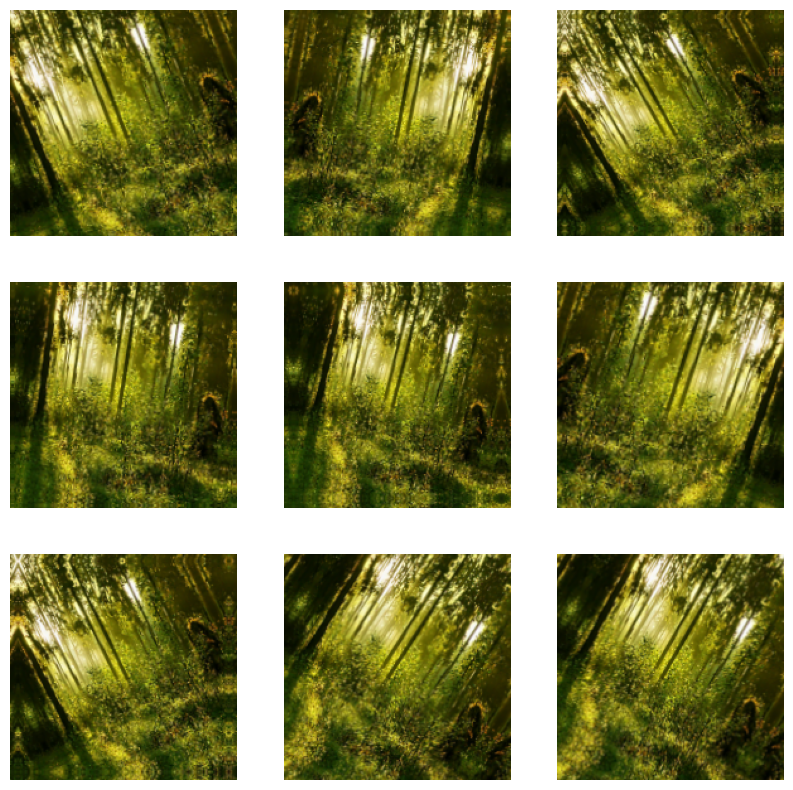

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [27]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
12/12 [==============================] - 16s 1s/step - loss: 0.9489 - accuracy: 0.4832 - val_loss: 0.7014 - val_accuracy: 0.4667
Epoch 2/15
12/12 [==============================] - 15s 1s/step - loss: 0.6917 - accuracy: 0.5726 - val_loss: 0.6851 - val_accuracy: 0.6889
Epoch 3/15
12/12 [==============================] - 15s 1s/step - loss: 0.6821 - accuracy: 0.6257 - val_loss: 0.6586 - val_accuracy: 0.7111
Epoch 4/15
12/12 [==============================] - 16s 1s/step - loss: 0.6591 - accuracy: 0.6397 - val_loss: 0.6426 - val_accuracy: 0.6000
Epoch 5/15
12/12 [==============================] - 14s 1s/step - loss: 0.6719 - accuracy: 0.6034 - val_loss: 0.6345 - val_accuracy: 0.6444
Epoch 6/15
12/12 [==============================] - 15s 1s/step - loss: 0.6488 - accuracy: 0.6061 - val_loss: 0.5856 - val_accuracy: 0.6889
Epoch 7/15
12/12 [==============================] - 14s 1s/step - loss: 0.5920 - accuracy: 0.6760 - val_loss: 0.6338 - val_accuracy: 0.6778
Epoch 8/15
12/12 [==

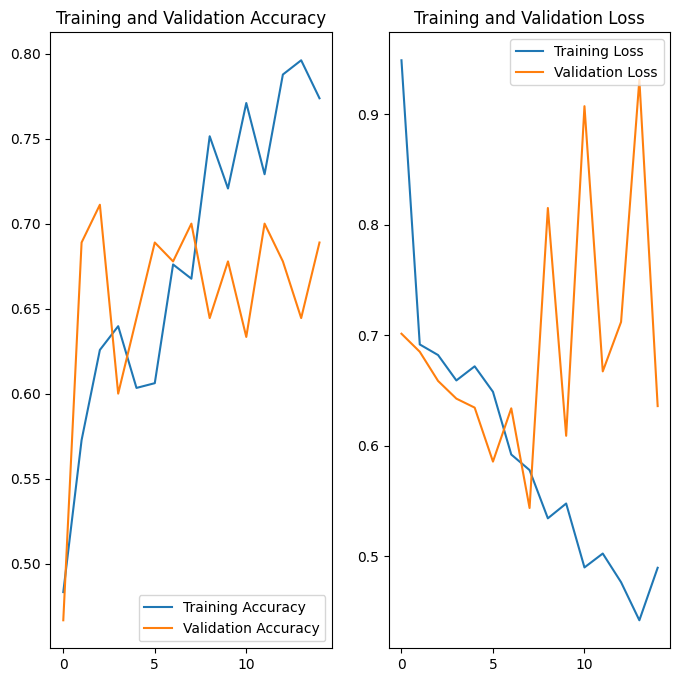

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)